In [1]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import math
# plt.style.use('dark_background')
plt.style.use('seaborn-notebook')
from collections import OrderedDict
from sklearn import preprocessing
import time
import torch
from torch.autograd import Variable
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")
import viz_losses, viz_weights

%load_ext autoreload
%autoreload 2

# load results from a directory

In [2]:
out_dir_main = '/scratch/users/vision/yu_dl/raaz.rsk/track_acts/'
print(os.listdir(out_dir_main))
folder = 'sweep_full_real'

['sweep_full_real', 'sweep_full_orig', 'sweep_full_high_seeds']


In [3]:
# depending on how much is saved, this may take a while
t = time.time()
out_dir = oj(out_dir_main, folder)
fnames = sorted(os.listdir(out_dir))
results_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in fnames if not fname.startswith('weights')]
results = pd.concat(results_list, axis=1).T.infer_objects()
print('time elapsed', time.time() - t)

save_dir = 'test'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

time elapsed 13.801066398620605


# plot basic things for entire dataframe

In [4]:
print('shape', results.shape)
print(np.unique(results.shuffle_labels, return_counts=True))
print(results.keys())

shape (750, 44)
(array([False,  True]), array([365, 385]))
Index(['accs_test', 'accs_test_r', 'accs_train', 'accs_train_r',
       'act_singular_val_dicts_test_pca', 'act_singular_val_dicts_test_rbf',
       'act_singular_val_dicts_train_pca', 'act_singular_val_dicts_train_rbf',
       'batch_size', 'calc_activations', 'dset', 'freeze', 'hidden_size',
       'its', 'losses_test', 'losses_test_r', 'losses_train', 'losses_train_r',
       'lr', 'lr_step', 'lr_ticks', 'mean_margin_test',
       'mean_margin_test_unnormalized', 'mean_margin_train',
       'mean_margin_train_unnormalized', 'num_iters', 'num_iters_small',
       'num_layers', 'optimizer', 'out_dir', 'save_acts_and_reduce',
       'save_all_weights_freq', 'saves_per_iter', 'saves_per_iter_end', 'seed',
       'shuffle_labels', 'singular_val_dicts_cosine', 'singular_val_dicts_lap',
       'singular_val_dicts_pca', 'singular_val_dicts_rbf', 'use_conv',
       'use_conv_special', 'weight_names', 'weight_norms'],
      dtype='obj

add vars that are useful

In [5]:
results['accs_test_final'] = np.array([x[-1] for x in results['accs_test']])

In [12]:
x = results[results['shuffle_labels']==True]['accs_test_final']
x = x[x < 2]
x = x[x > .5]
print(np.mean(x), x)

1.0119268292682921 11     1.017
13     1.135
16     0.801
17     0.934
23     1.000
24     0.892
28     0.982
30     0.946
31     0.860
46     0.982
67     1.360
84     0.985
88     0.892
101    1.000
133    1.000
145    0.892
147    1.141
151    1.000
159    1.021
166    1.140
167    1.385
178    1.023
183    0.939
190    1.059
197    0.978
199    1.319
200    1.524
209    1.351
211    0.856
212    0.832
       ...  
544    1.000
551    1.143
570    1.000
588    1.057
595    1.189
598    1.000
620    1.312
622    0.809
624    0.972
629    1.000
630    1.074
633    1.059
635    1.000
638    1.233
639    0.982
655    0.982
656    1.000
663    0.892
667    1.002
676    0.958
686    0.980
688    0.892
689    0.868
711    1.006
713    1.040
722    0.982
735    1.188
739    0.740
747    1.000
749    1.013
Name: accs_test_final, Length: 123, dtype: float64


# take mean over seed

In [22]:
# grouping vars: seed, lr, optimizer, num_layers, dset, batch_size
sweep_vars = ['lr', 'optimizer', 'num_layers', 'dset', 'batch_size', 'shuffle_labels']

# mean over seed (note this eliminates any vars that aren't scalars)
r = results.groupby(sweep_vars).mean().reset_index()

# max over different runs
r = r.groupby(['lr', 'optimizer', 'num_layers', 'dset', 'batch_size'])

In [24]:
r.head()

,lr,optimizer,num_layers,dset,batch_size,shuffle_labels,calc_activations,freeze,hidden_size,lr_step,num_iters,num_iters_small,save_acts_and_reduce,save_all_weights_freq,saves_per_iter,saves_per_iter_end,seed,use_conv,use_conv_special,accs_test_final
0,0.001,adam,2,cifar10,10,False,8000.0,False,512.0,16.0,160.0,10.0,True,20.0,5.0,2.0,1.0,False,False,0.050815
1,0.001,adam,2,cifar10,10,True,8000.0,False,512.0,16.0,160.0,10.0,True,20.0,5.0,2.0,1.0,False,False,0.009783
2,0.001,adam,2,cifar10,100,False,8000.0,False,512.0,16.0,160.0,10.0,True,20.0,5.0,2.0,0.5,False,False,0.536250
3,0.001,adam,2,cifar10,100,True,8000.0,False,512.0,16.0,160.0,10.0,True,20.0,5.0,2.0,1.0,False,False,0.101600
4,0.001,adam,2,cifar10,1000,False,8000.0,False,512.0,16.0,160.0,10.0,True,20.0,5.0,2.0,1.0,False,False,5.355333
5,0.001,adam,2,cifar10,1000,True,8000.0,False,512.0,16.0,160.0,10.0,True,20.0,5.0,2.0,1.0,False,False,1.031667
6,0.001,adam,2,mnist,10,False,8000.0,False,512.0,16.0,160.0,10.0,True,20.0,5.0,2.0,0.5,False,False,0.098320
7,0.001,adam,2,mnist,10,True,8000.0,False,512.0,16.0,160.0,10.0,True,20.0,5.0,2.0,1.0,False,False,0.009520
8,0.001,adam,2,mnist,100,False,8000.0,False,512.0,16.0,160.0,10.0,True,20.0,5.0,2.0,1.0,False,False,0.984133
9,0.001,adam,2,mnist,100,True,8000.0,False,512.0,16.0,160.0,10.0,True,20.0,5.0,2.0,1.0,False,False,0.094100


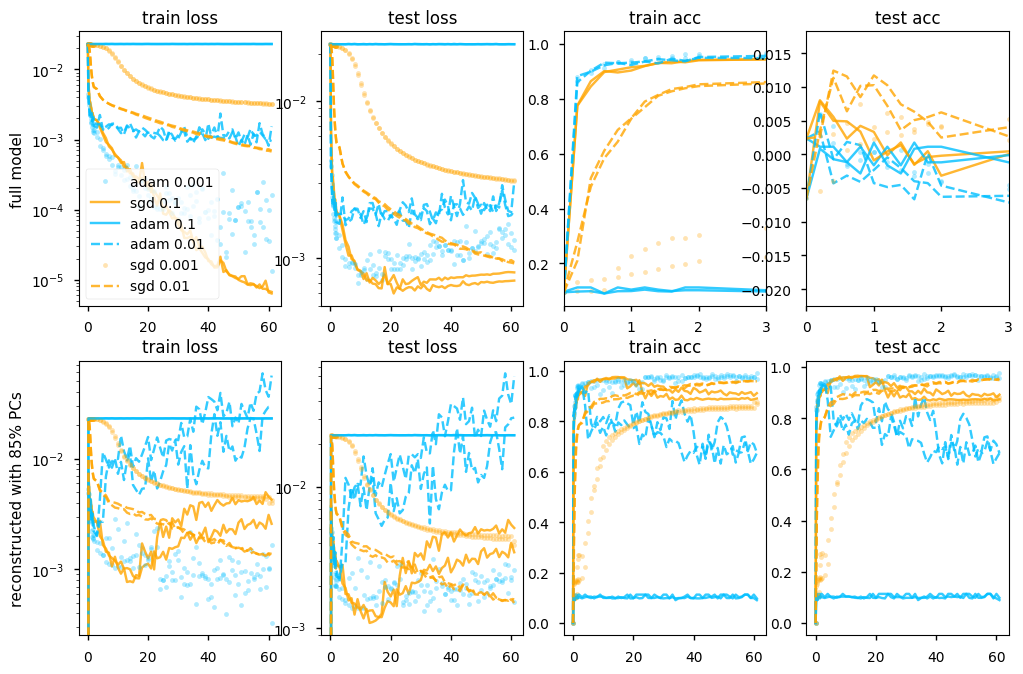

In [10]:
viz_losses.plot_losses(results, out_dir=save_dir)

In [ ]:
all_w = ['explained_var_dicts_pca', 'explained_var_dicts_rbf', 'explained_var_dicts_lap', 'explained_var_dicts_cosine']
acts = ['act_var_dicts_train_pca', 'act_var_dicts_test_pca', 'act_var_dicts_train_rbf', 'act_var_dicts_test_rbf']
viz_losses.plot_dims(results, out_dir=save_dir, xlim=None, dim_types=all_w, figname='ws')
# viz_losses.plot_dims(results, out_dir=save_dir, xlim=None, dim_types=acts, figname='acts')

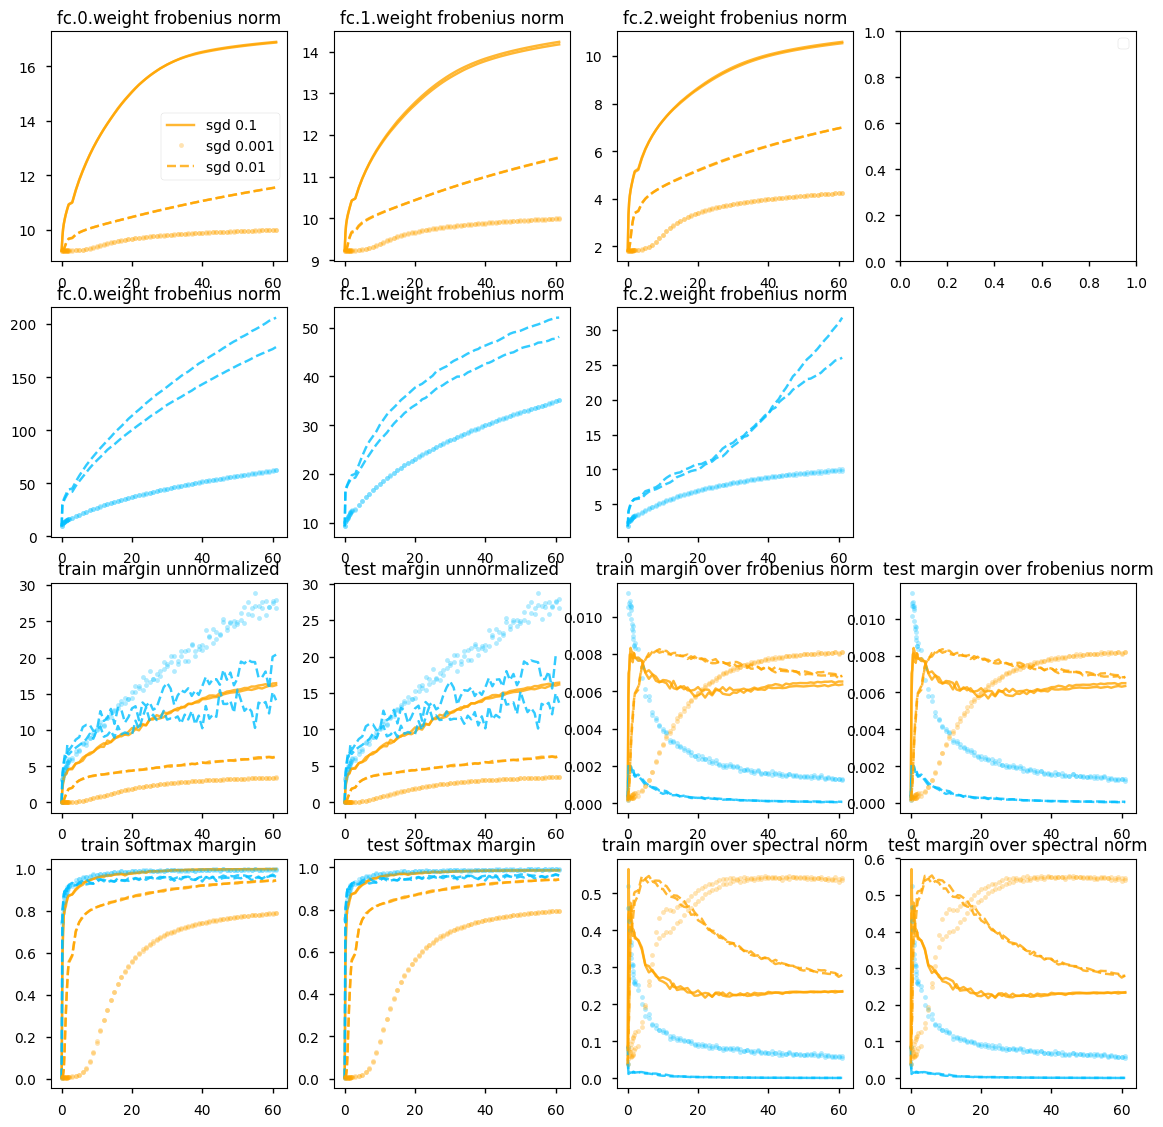

In [13]:
# note these norms were squared
# calculated via np.linalg.norm(weight_dict[lay_name])**2
viz_losses.plot_weight_norms_and_margin(results, out_dir='test')    

In [ ]:
all_w = ['explained_var_dicts_pca', 'explained_var_dicts_rbf', 'explained_var_dicts_lap', 'explained_var_dicts_cosine']
acts = ['act_var_dicts_train_pca', 'act_var_dicts_test_pca', 'act_var_dicts_train_rbf', 'act_var_dicts_test_rbf']
viz_losses.plot_dims_flexible(results, out_dir='test', xlim=None, dim_types=all_w, figname='ws')
# viz_losses.plot_dims(results, out_dir=save_dir, xlim=None, dim_types=all_w, figname='acts')    

# look at the weights

In [ ]:
# depending on how much is saved, this may take a while
weights_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in fnames if fname.startswith('weights')]
results_weights = pd.concat(weights_list, axis=1).T.infer_objects()
# results.head()
# results_weights.dtypes

just plot them all (this takes ~2 mins)

In [ ]:
viz_weights.save_final_weights(results_weights, results, out_dir=save_dir)

In [ ]:
viz_weights.save_weight_evol(results_weights, out_dir=save_dir)

# other stuff not really used...

*compare dimensionality between sizes*

*visualize pcs*

In [ ]:
# pca
optimizer, lr = 'adam', 0.01

# get w
runs = results_weights[results_weights.lr==lr]
runs = runs[runs.optimizer==optimizer]
run = runs.iloc[0]
weight_dict = run.weights
w = weight_dict[max(weight_dict.keys())]['fc1.weight']

# look at pcs
pca = PCA(n_components=w.shape[1])
pca.fit(w)
cum = deepcopy(pca.explained_variance_ratio_)
for i in range(1, len(cum)):
    cum[i] += cum[i-1]
plt.plot(cum, 'o')
plt.ylabel('cumulative explained var')
plt.xlabel('num pcs')
plt.show()

print('first pcs..')
plot_weights(pca.components_[:200], run.dset)
plt.show()

*norm distributions*

In [ ]:
# pca
plt.figure(figsize=(9, 5))
R, C = 2, 3
for j, optimizer in enumerate(['sgd', 'adam']):
    for lr in [0.1, 0.01, 0.001]:
        if not (optimizer == 'adam' and lr == 0.1):
            # get ws
            runs = results_weights[results_weights.lr==lr]
            runs = runs[runs.optimizer==optimizer]
            run = runs.iloc[0]
            weight_dict_list = run.weights
            weight_dict = weight_dict_list[max(weight_dict_list.keys())]
            ws = [weight_dict['fc1.weight'], weight_dict['fc2.weight'], weight_dict['fc3.weight']]
            w_norms = [np.sum(np.abs(w)**2, axis=1)**(1./2) for w in ws]
    #         w_norms = [np.sum(np.abs(w)**1, axis=1)**(1./1) for w in ws]        

            plt.subplot(R, C, 1 + j * C)
            plt.hist(w_norms[0], label=str(lr))
            if j == 0:
                plt.title('lay1 norms')
            plt.ylabel(optimizer)

            plt.subplot(R, C, 2 + j * C)    
            plt.hist(w_norms[1], label=str(lr))
            if j == 0:
                plt.title('lay2 norms')    

            plt.subplot(R, C, 3 + j * C)    
            plt.hist(w_norms[2], label=str(lr))
            if j == 0:
                plt.title('lay3 norms')              
plt.legend()
plt.show()